# Maritime Trade: Train 2019 XGBoost RAPIDS GPU
## Hyperopt Hyperparameter Optimization

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
# Install/import dependencies
!pip install --upgrade pip
!pip install category_encoders
!pip install xgboost==1.5.2
!pip install hyperopt
!pip install eli5
import os
import warnings
import random
import numpy as np
import cupy
from cupy import asnumpy
import dask
from dask.distributed import Client, wait
from dask.diagnostics import ProgressBar
from dask_cuda import LocalCUDACluster
import dask_cudf
import urllib.request
from contextlib import contextmanager
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import cudf
import cuml
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor, plot_importance
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import csv
import ast
import joblib
import pickle
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
import webbrowser
from eli5.formatters import format_as_dataframe
warnings.filterwarnings('ignore')
my_dpi = 96
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Set seed
seed_value = 42
os.environ['xgbRAPIDS_GPU'] = str(seed_value)
random.seed(seed_value)
cupy.random.seed(seed_value)
np.random.seed(seed_value)

# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

print('\n')
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.3
    Uninstalling pip-22.0.3:
      Successfully uninstalled pip-22.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 97.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=c2c3be805635ae50058bf5f0937515a541edc78adc321367838fd6e166adc6bf
  Stored in directory: /root/.cache/pip/wheels/96/66/19/2de75120f5d0bc185e9d16cf0fd223d8471ed025de08e45867
Successfully built future
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py)

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='',
                           dashboard_address='8081')
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://10.42.49.230:8081/status,
Dashboard: http://10.42.49.230:8081/status,Workers: 1
Total threads: 1,Total memory: 39.94 GiB
Status: running,Using processes: True
Comm: tcp://10.42.49.230:33895,Workers: 1
Dashboard: http://10.42.49.230:8081/status,Total threads: 1
Started: Just now,Total memory: 39.94 GiB
Comm: tcp://10.42.49.230:39091,Total threads: 1
Dashboard: http://10.42.49.230:36175/status,Memory: 39.94 GiB
Nanny: tcp://10.42.49.230:41701,


In [ ]:
%cd /datasets/maritime_trade1920

/datasets/maritime_trade1920


In [ ]:
# Read data
df = cudf.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Create year-week for stratification
df['DateTime']= cudf.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

df = df.drop(['DateTime'], axis=1)

In [ ]:
# Filter df to 2019
df1 = df[df['Year'] == 2019]

# Filter df to 2020
df2 = df[df['Year'] == 2020]

# Drop year variable
df1 = df1.drop(['Year'], axis=1)
df1 = df1.to_pandas()
df2 = df2.drop(['Year'], axis=1)
df2 = df2.to_pandas()

del df

In [ ]:
# Prepare for partitioning data
X = df1.drop(['Metric_Tons'], axis=1)
y = df1['Metric_Tons']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=seed_value)

In [ ]:
# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.transform(X_test)

# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mn.transform(X_test), columns=X_test.columns)

# Convert back to cudf
X_train = cudf.DataFrame.from_pandas(X_train)
X_test = cudf.DataFrame.from_pandas(X_test)

# Convert data type for modeling
X_train = X_train.astype('float32')
y_train = y_train.astype('int32')

X_test = X_test.astype('float32')
y_test = y_test.astype('int32')

## Baseline Model

In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Set the baseline model
xgb = XGBRegressor(objective='reg:squarederror',
                   booster='gbtree',
                   tree_method='gpu_hist',
                   scale_pos_weight=1,
                   use_label_encoder=False,
                   random_state=seed_value,
                   verbosity=0)

# Fit the model to the data
xgb.fit(X_train, y_train)

# Save model
Pkl_Filename = 'XGB_Train19_Baseline.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(xgb, file)

# =============================================================================
# # To load saved model
# model = joblib.load('XGB_Train19_Baseline.pkl')
# print(model)
# =============================================================================

# Predict based on training
print('\nModel Metrics for XGBoost Baseline Train 2019 Test 2019')
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred),
                           squared=False),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred),
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test), asnumpy(y_test_pred))))


Model Metrics for XGBoost Baseline Train 2019 Test 2019
MAE train: 8.066, test: 8.111
MSE train: 288.531, test: 292.210
RMSE train: 16.986, test: 17.094
R^2 train: 0.713, test: 0.709


## 100 Trials Train/Test

In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Define the number of trials
NUM_EVAL = 100

# Parameter space
xgb_tune_kwargs= {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 700, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 25, dtype=int)),
    'subsample': hp.uniform('subsample', 0.25, 0.95),
    'gamma': hp.uniform('gamma', 0, 15),
    'learning_rate': hp.uniform('learning_rate', 1e-3, 0.3),
    'reg_alpha': hp.choice('reg_alpha', np.arange(0, 30, dtype=int)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.05, 0.95),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 30,
                                                                dtype=int))
    }

In [ ]:
# Define a function for optimization of hyperparameters
def xgb_hpo(config):

    """
    Objective function to tune a `XGBoostRegressor` model.
    """
    joblib.dump(bayesOpt_trials, 'xgbRapids_Hyperopt_100_GPU_Train19.pkl')

    # Keep track of evaluations
    global ITERATION

    ITERATION += 1

    # Parameters that are integers to remain integers
    config['n_estimators'] = int(config['n_estimators'])

    # Start hyperopt at 3 for max_depth
    config['max_depth'] = int(config['max_depth']) + 3

    # Define model type
    xgb = XGBRegressor(objective='reg:squarederror',
                       booster='gbtree',
                       tree_method='gpu_hist',
                       scale_pos_weight=1,
                       use_label_encoder=False,
                       random_state=seed_value,
                       verbosity=0,
                       **config)

    # Start timer for each trial
    start = timer()

    # Fit model
    xgb.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=0)
    run_time = timer() - start

    # Predictions
    y_pred_val = xgb.predict(X_test)
    mae = mean_absolute_error(asnumpy(y_test), asnumpy(y_pred_val))

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([mae, config, ITERATION, run_time])

    return {'loss': mae, 'params': config, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [ ]:
# Optimization algorithm
tpe_algorithm = tpe.suggest

# File to save results
out_file = '/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions/xgbRapids_HPO_Train19_100_GPU.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

# Set global variable and HPO is run with fmin
global ITERATION
ITERATION = 0
bayesOpt_trials = Trials()

In [ ]:
# Begin HPO trials
if os.path.isfile('xgbRapids_Hyperopt_100_GPU_Train19.pkl'):
    bayesOpt_trials = joblib.load('xgbRapids_Hyperopt_100_GPU_Train19.pkl')
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                      max_evals=NUM_EVAL, trials=bayesOpt_trials)
else:
    best_param = fmin(xgb_hpo, xgb_tune_kwargs, algo=tpe.suggest,
                      max_evals=NUM_EVAL, trials=bayesOpt_trials)

 90%|█████████ | 90/100 [4:53:40<1:19:24, 476.48s/trial, best loss: 4.866573237785186]

In [ ]:
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/trialOptions


In [ ]:
# Access results
results = pd.read_csv('xgbRapids_HPO_Train19_100_GPU.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending=True, inplace=True)
results.reset_index(inplace=True, drop=True)
results.to_csv('xgbRapids_HPO_Train19_100_GPU.csv', index=False)

# Convert from a string to a dictionary for later use
ast.literal_eval(results.loc[0, 'params'])

# Evaluate Best Results
# Extract the ideal number hyperparameters
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL/

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_PKL


In [ ]:
# Re-create the best model and train on the training data
best_bayes_model = XGBRegressor(objective='reg:squarederror',
                                booster='gbtree',
                                tree_method='gpu_hist',
                                scale_pos_weight=1,
                                use_label_encoder=False,
                                random_state=seed_value,
                                verbosity=0,
                                **best_bayes_params)

# Fit the model
best_bayes_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'xgbRapids_Hyperopt_100_GPU_Train19trials.pkl'

with open(Pkl_Filename, 'wb') as file:
    pickle.dump(best_bayes_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('xgbRapids_Hyperopt_100_GPU_Train19trials.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for XGBoost HPO Train 2019 100 GPU trials')
y_train_pred = best_bayes_model.predict(X_train)
y_test_pred = best_bayes_model.predict(X_test)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred),
                           squared=False),
        mean_squared_error(asnumpy(y_test), asnumpy(y_test_pred),
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test), asnumpy(y_test_pred))))


Model Metrics for XGBoost HPO Train 2019 100 GPU trials
MAE train: 3.648, test: 4.867
MSE train: 78.764, test: 159.370
RMSE train: 8.875, test: 12.624
R^2 train: 0.922, test: 0.842


In [ ]:
# Evaluate on the testing data
print('The best model from Bayes optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(asnumpy(y_test),
                                                                                                            asnumpy(y_test_pred))))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 159.36986 MSE on the test set.
This was achieved after 79 search iterations


In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams/

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/bayesParams


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns=list(ast.literal_eval(results.loc[0,
                                                                      'params']).keys()),
                            index=list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

# Save dataframes of parameters
bayes_params.to_csv('bayes_params_xgbRapids_HPO_Train19_100_GPU.csv',
                    index=False)

In [ ]:
# Convert data types for graphing
bayes_params['colsample_bylevel'] = bayes_params['colsample_bylevel'].astype('float64')
bayes_params['colsample_bytree'] = bayes_params['colsample_bytree'].astype('float64')
bayes_params['gamma'] = bayes_params['gamma'].astype('float64')
bayes_params['learning_rate'] = bayes_params['learning_rate'].astype('float64')
bayes_params['reg_alpha'] = bayes_params['reg_alpha'].astype('float64')
bayes_params['reg_lambda'] = bayes_params['reg_lambda'].astype('float64')
bayes_params['subsample'] = bayes_params['subsample'].astype('float64')

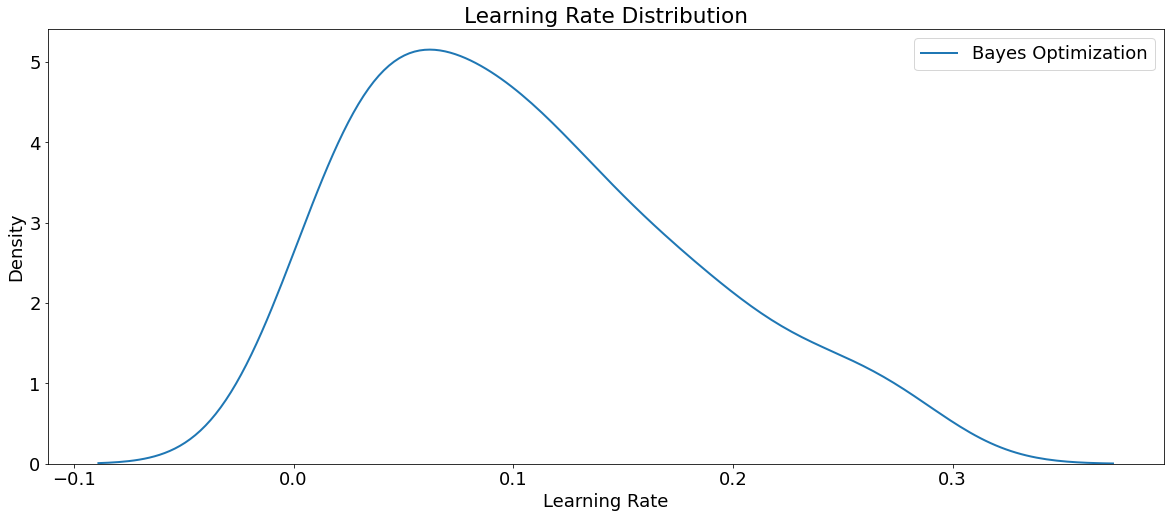

In [ ]:
# Density plots of the learning rate distributions
plt.figure(figsize=(20,8))
plt.rcParams['font.size'] = 18
sns.kdeplot(bayes_params['learning_rate'], label='Bayes Optimization',
            linewidth=2)
plt.legend(loc=1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

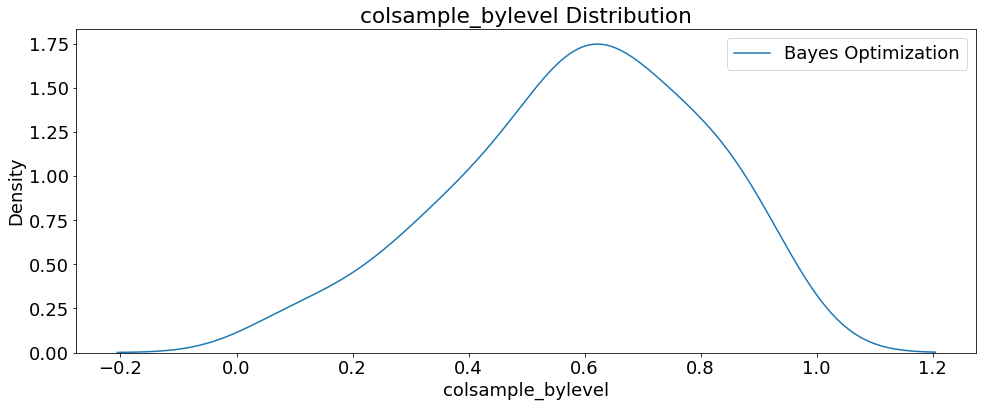

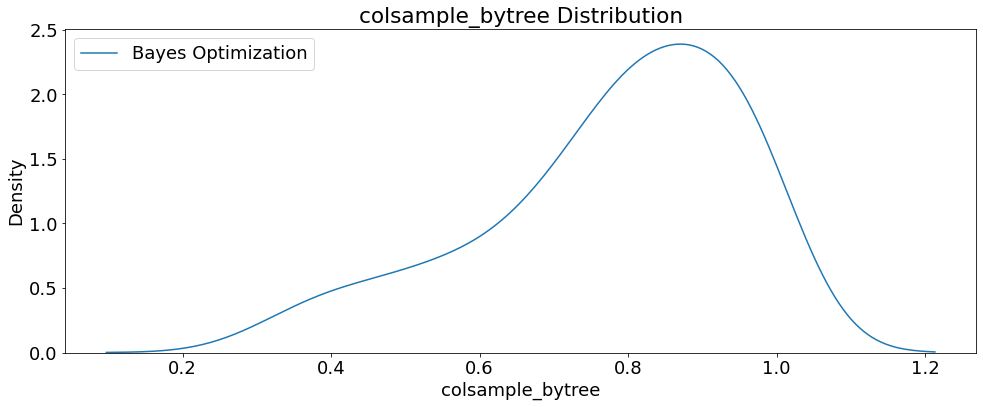

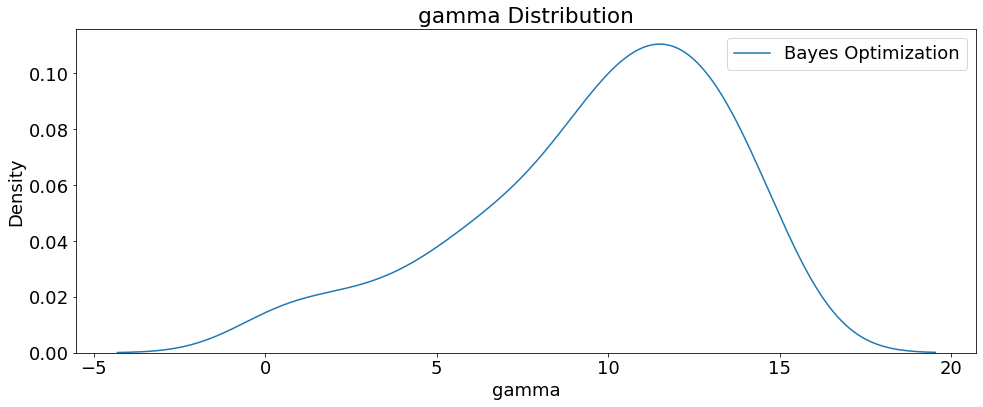

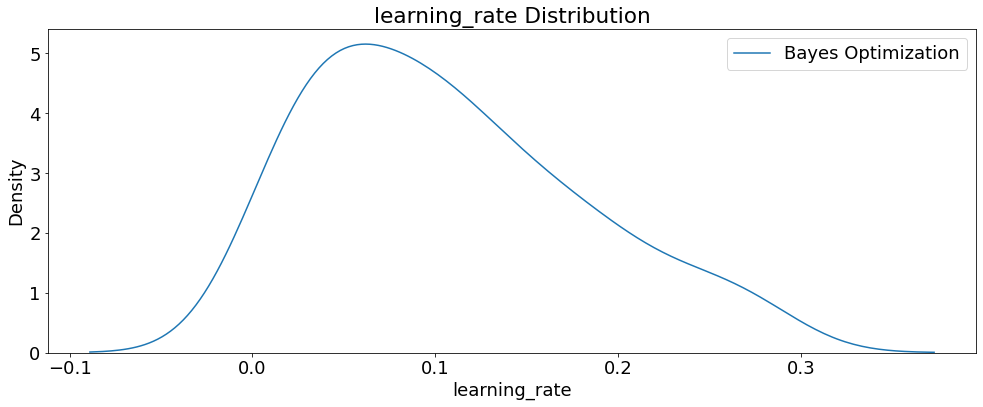

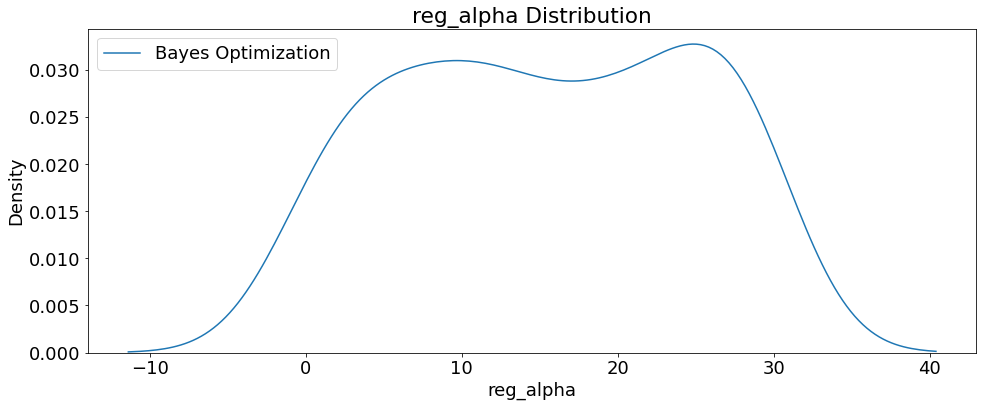

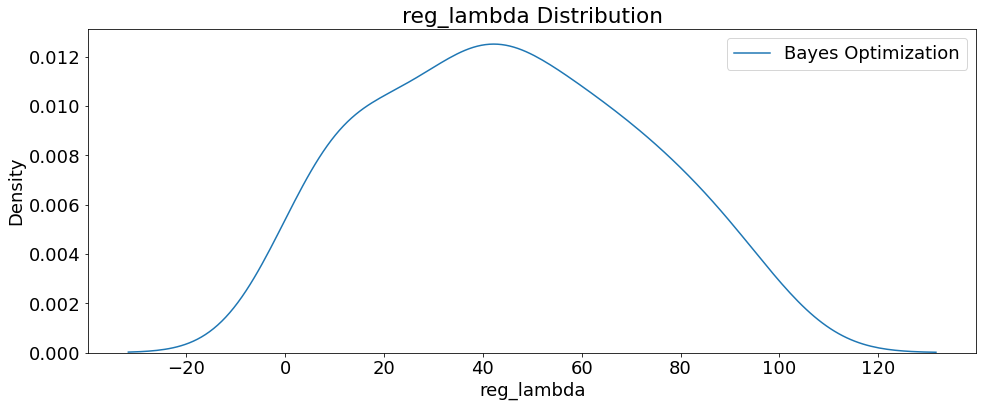

<Figure size 1008x432 with 0 Axes>

In [ ]:
# Create plots of Hyperparameters that are numeric
for i, hpo in enumerate(bayes_params.columns):
    if hpo not in ['iteration', 'subsample', 'force_col_wise',
                   'max_depth', 'min_child_weight', 'n_estimators']:
        plt.figure(figsize=(14,6))
        # Plot the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(bayes_params[hpo], label='Bayes Optimization')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

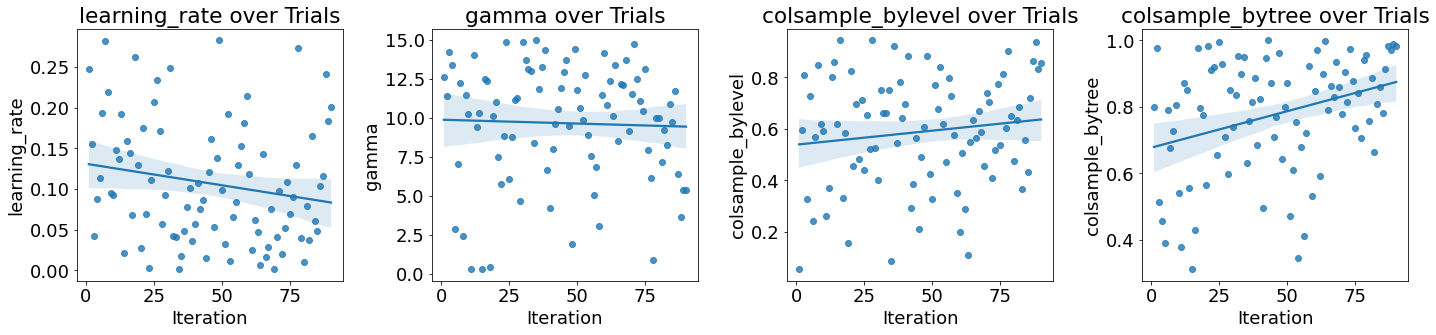

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
    # Scatterplot
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

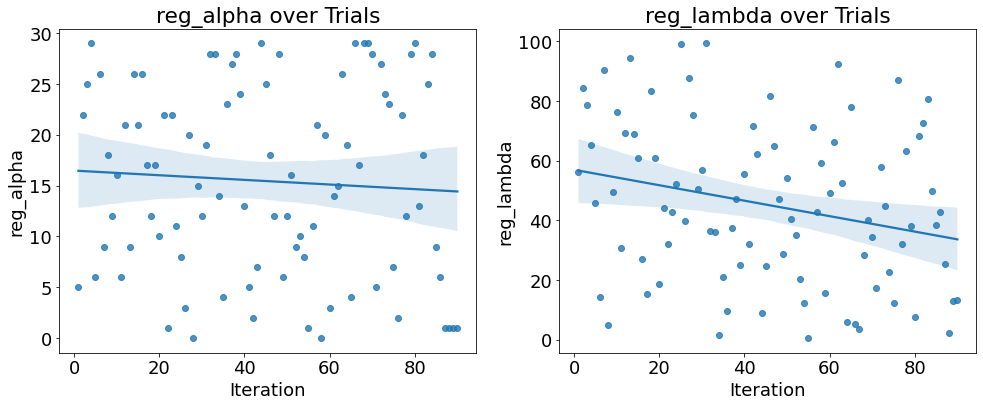

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14,6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
    sns.regplot('iteration', hpo, data=bayes_params, ax=axs[i])
    axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),
               title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


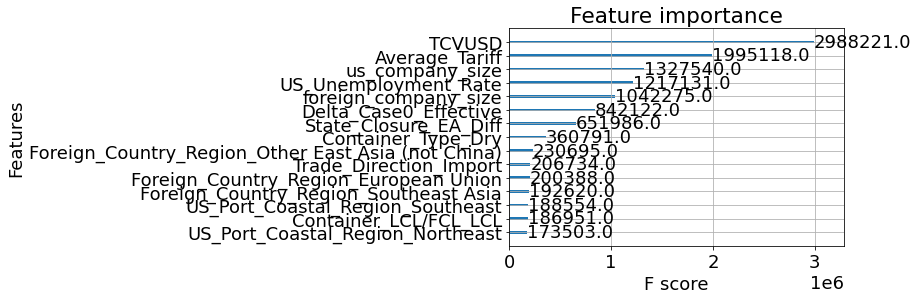

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_model, max_num_features=15)
plt.savefig('xgbRapids_HPO_train19test19_100_GPU_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test.to_numpy(),
                                                                     y_test.to_numpy())

In [ ]:
# Get the weights
X_test1 = pd.DataFrame(X_test.to_pandas(), columns=X_test.columns)

# Store feature weights in an object
html_obj = eli5.show_weights(perm_importance,
                             feature_names=X_test1.columns.tolist())

# Write feature weights html object to a file
with open(r'/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train19test19_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train19test19_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.1473 ± 0.0044,TCVUSD
0.4113 ± 0.0021,Average_Tariff
0.2373 ± 0.0030,HS_Group_Name_Finished Goods
0.2333 ± 0.0019,foreign_company_size
0.1867 ± 0.0010,HS_Group_Name_Raw Input
0.1276 ± 0.0027,us_company_size
0.1028 ± 0.0012,Trade_Direction_Import
0.0674 ± 0.0004,Delta_Case0_Effective
0.0455 ± 0.0010,Foreign_Country_Region_European Union
0.0440 ± 0.0010,Container_Type_Dry


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_xgbRapids_HPO_100_GPU_train19test19_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,TCVUSD,1.147259,0.002200
1,Average_Tariff,0.411251,0.001070
2,HS_Group_Name_Finished Goods,0.237294,0.001476
3,foreign_company_size,0.233340,0.000927
4,HS_Group_Name_Raw Input,0.186702,0.000506
5,us_company_size,0.127631,0.001374
6,Trade_Direction_Import,0.102769,0.000616
7,Delta_Case0_Effective,0.067358,0.000208
8,Foreign_Country_Region_European Union,0.045470,0.000501
9,Container_Type_Dry,0.043954,0.000479


### Test on 2020

In [ ]:
# Prepare 2020 to fit model train on 2019
X_test1 = df2.drop(['Metric_Tons', 'DateTime_YearWeek'], axis=1)
y_test1 = df2['Metric_Tons']

# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test1 = ce_ord.fit_transform(X_test1)

# Create dummy variables for categorical variables
X_test1 = pd.get_dummies(X_test1, drop_first=True)

# MinMax Scaling
X_test1 = pd.DataFrame(mn.transform(X_test1), columns=X_test1.columns)

# Convert data type for modeling
X_test1 = cudf.DataFrame.from_pandas(X_test1)

# Convert data type for modeling
X_test1 = X_test1.astype('float32')
y_test1 = y_test1.astype('int32')

In [ ]:
# Fit the model
best_bayes_model.fit(X_test1, y_test1)

# Model Metrics
print('\nModel Metrics for XGBoost HPO Train 2019 Test 2020')
y_test_pred = best_bayes_model.predict(X_test1)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_absolute_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred)),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred))))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(asnumpy(y_train), asnumpy(y_train_pred),
                           squared=False),
        mean_squared_error(asnumpy(y_test1), asnumpy(y_test_pred),
                           squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(asnumpy(y_train), asnumpy(y_train_pred)),
        r2_score(asnumpy(y_test1), asnumpy(y_test_pred))))


Model Metrics for XGBoost HPO Train 2019 Test 2020
MAE train: 3.648, test: 3.078
MSE train: 78.764, test: 47.848
RMSE train: 8.875, test: 6.917
R^2 train: 0.922, test: 0.949


In [ ]:
# Write results to ML Results
%cd /notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/

/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations


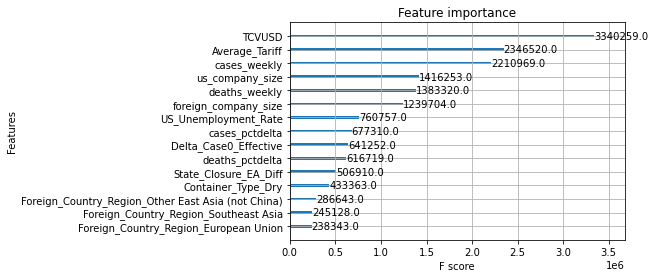

In [ ]:
# Plot the feature importance from best model result
plot_importance(best_bayes_modeL, max_num_features=15)
plt.savefig('xgbRapids_HPO_100_GPU_train19test20_FeatureImportance.png',
            dpi=my_dpi*10, bbox_inches='tight');

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_bayes_model,
                                        random_state=seed_value).fit(X_test1.to_numpy(),
                                                                     y_test1.to_numpy())

In [ ]:
# Store feature weights in an object
X1_test1 = pd.DataFrame(X_test1.to_pandas(), columns=X_test1.columns)

html_obj = eli5.show_weights(perm_importance,
                             feature_names=X1_test1.columns.tolist())

# Write feature weights html object to a file
with open(r'/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train19test20_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode('UTF-8'))

# Open the stored feature weights HTML file
url = r'/notebooks/MaritimeTrade/Models/ML/XGBoost/Hyperopt/Model_Explanations/best_bayes_xgbRapids_HPO_100_GPU_train19test20_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

Weight,Feature
1.2129 ± 0.0016,TCVUSD
0.4724 ± 0.0010,Average_Tariff
0.2595 ± 0.0020,HS_Group_Name_Finished Goods
0.2098 ± 0.0006,Trade_Direction_Import
0.1989 ± 0.0005,HS_Group_Name_Raw Input
0.1586 ± 0.0007,us_company_size
0.1164 ± 0.0006,foreign_company_size
0.0752 ± 0.0005,Delta_Case0_Effective
0.0515 ± 0.0004,Foreign_Country_Region_European Union
0.0502 ± 0.0002,HS_Group_Name_Edible with Processing


In [ ]:
# Explain weights
explanation = eli5.explain_weights_sklearn(perm_importance,
                                           feature_names=X1_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_xgbRapids_HPO_100_GPU_train19test20_WeightsExplain.csv',
           index=False)
exp

,feature,weight,std
0,TCVUSD,1.212947,0.000782
1,Average_Tariff,0.472409,0.000507
2,HS_Group_Name_Finished Goods,0.259453,0.001015
3,Trade_Direction_Import,0.209795,0.000313
4,HS_Group_Name_Raw Input,0.198903,0.000271
5,us_company_size,0.158599,0.000346
6,foreign_company_size,0.116391,0.000299
7,Delta_Case0_Effective,0.075206,0.000244
8,Foreign_Country_Region_European Union,0.051508,0.000195
9,HS_Group_Name_Edible with Processing,0.050237,0.000080
